Input Image -> VAE Encoder -> latents -> add Noise -> patchify -> input to Transformer

In [2]:
import torch.nn as nn
import torch
from diffusers import AutoencoderDC
from diffusers import DDPMScheduler, DDIMScheduler
from CombinationFunctions import PatchEmbedding
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

(torch.Size([1, 16, 768]), torch.Size([1, 128, 8, 8]))

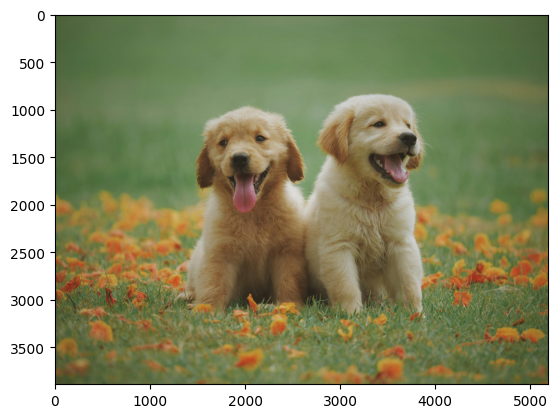

In [3]:
class ImageInputToDiT(nn.Module):
    def __init__(self, latentSize, latentChannels, embedDimension, patchSize, totalTimestamps = 1000, beta_schedule = "squaredcos_cap_v2", modelName="mit-han-lab/dc-ae-f64c128-in-1.0-diffusers"):
        super().__init__()

        self.dc_ae = AutoencoderDC.from_pretrained(modelName, torch_dtype=torch.float32)
        self.noiseScheduler = DDPMScheduler(num_train_timesteps=totalTimestamps, beta_schedule=beta_schedule)
        self.patchEmbedding = PatchEmbedding(imageSize = latentSize, patchSize = patchSize, inChannels = latentChannels, embedDimension = embedDimension)

    def forward(self, x, timestamp):

        with torch.no_grad():
            latents = self.dc_ae.encode(x).latent

        noise = torch.randn_like(latents)
        alphaT = self.noiseScheduler.alphas_cumprod[timestamp].view(1, 1, 1, 1)
        noisyLatents = torch.sqrt(alphaT) * latents + torch.sqrt(1 - alphaT) * noise
        
        patches = self.patchEmbedding(noisyLatents)

        return patches, noise


preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),                 
    transforms.Normalize([0.5]*3, [0.5]*3)])

image = Image.open("Images/testImage.jpg").convert("RGB")
plt.imshow(image)
image_tensor = preprocess(image).unsqueeze(0)
# image_tensor = torch.randn(1, 3, 512, 512)

imgenc = ImageInputToDiT(latentSize = 8, latentChannels = 128, embedDimension = 768, patchSize = 2)
patches, noise = imgenc(image_tensor, 10)
patches.shape, noise.shape

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

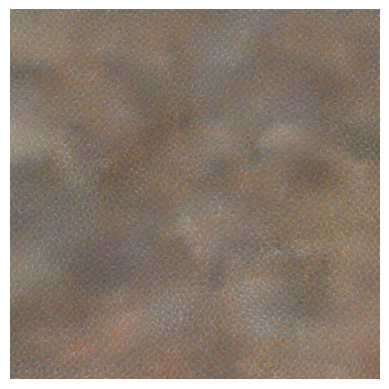

In [ ]:
def removeNoise(noisyImage, timestep, noise, noiseScheduler):
    alphaT = noiseScheduler.alphas_cumprod[timestep].view(1, 1, 1, 1)
    originalImage = (noisyImage - torch.sqrt(1 - alphaT) * noise) / torch.sqrt(alphaT)
    return originalImage

unPatichifiedImage = imgenc.patchEmbedding.unPatchify(patches).squeeze(0)
img = removeNoise(unPatichifiedImage, 10, noise, imgenc.noiseScheduler)
img = imgenc.dc_ae.decode(img).sample
img = img * 0.5 + 0.5
img = transforms.ToPILImage()(img.squeeze(0))

plt.imshow(img)
plt.axis('off')